# 4. Pretraining On Unlabeled Data

## 4.1 Evaluating Generative Text Models

### 4.1.1 GPT-124M Configuration Setup and Model Import

In [9]:
from gpt_modules import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [10]:
import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();

### 4.1.2 Text-to-Tokens, Generation, and Decoding Pipeline

In [11]:
import tiktoken
from gpt_modules import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'}) # Encode text into token IDs (allow GPT special tokens if present)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension → shape becomes (1, seq_len)
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist()) # Convert token IDs back to readable text


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

# Generate new tokens autoregressively
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

# Decode generated token IDs back into text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### 4.1.3 Calculating The Text Generation Loss: Cross-Entropy And Perplexity

Example Input and Target Token Batches for Next-Token Prediction

In [12]:
inputs = torch.tensor([
    [16833, 3626, 6100],   # "every effort moves"
    [40,    1107, 588]     # "I really like"
])

targets = torch.tensor([
    [3626, 6100, 345],     # "effort moves you"
    [1107, 588, 11311]     # "really like chocolate"
])

Computing Token Probabilities from Model Logits

In [13]:
with torch.no_grad():                # Disable gradients for inference
    logits = model(inputs)           # Forward pass → raw logits (batch, seq_len, vocab_size)

probas = torch.softmax(logits, dim=-1)  # Convert logits to probabilities over vocabulary
print(probas.shape)                      # Expected: (batch_size, seq_len, vocab_size)

torch.Size([2, 3, 50257])


Selecting Most Probable Token IDs (Greedy Prediction)

In [14]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)  
# Select highest-probability token at each position (greedy decoding)

print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


Comparing Target Tokens with Model Predictions (Decoded Text)

In [15]:
# Decode target tokens for batch 1
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")

# Decode predicted token IDs for batch 1
# Flatten removes extra dimension from argmax output
print(f"Outputs batch 1: "
      f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


Extracting Model Probabilities for Target Tokens

In [16]:
text_idx = 0
# Get probabilities assigned to the correct target tokens for batch 1
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
# Same extraction for batch 2
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


Computing Log Probabilities of Target Tokens

In [17]:
# Combine probabilities from both batches and convert to log-probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))

print(log_probas)  # Log probabilities used in cross-entropy / likelihood calculations

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Computing Average Log Probability of Targets

In [18]:
# Compute average log probability across all target tokens
avg_log_probas = torch.mean(log_probas)

print(avg_log_probas)  # Higher (less negative) means better predictions

tensor(-10.7940)


Computing Negative Average Log Probability (Loss Value)

In [19]:
# Convert average log probability into negative log-likelihood (loss)
neg_avg_log_probas = avg_log_probas * -1

print(neg_avg_log_probas)  # Equivalent to cross-entropy style loss

tensor(10.7940)


Inspecting Logits and Target Tensor Shapes

In [20]:
print("Logits shape:", logits.shape)    # Expected: (batch_size, seq_len, vocab_size)
print("Targets shape:", targets.shape)  # Expected: (batch_size, seq_len)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


Flattening Logits and Targets for Loss Computation

In [21]:
# Merge batch and sequence dimensions to match loss function expectations
logits_flat = logits.flatten(0, 1)   # Shape: (batch_size * seq_len, vocab_size)
targets_flat = targets.flatten()     # Shape: (batch_size * seq_len)

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Computing Cross-Entropy Loss for Next-Token Prediction

In [22]:
# Compute cross-entropy loss between predicted logits and true token IDs
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

print(loss)  # Standard language modeling loss (negative log-likelihood)

tensor(10.7940)


### 4.1.4 Calculating the training and validation set losses

Loading Text Dataset and Counting Characters & Tokens

In [23]:
file_path = "../dataset/the_verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
    
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Splitting Dataset into Training and Validation Sets

In [24]:
train_ratio = 0.90                              # Use 90% of data for training
split_idx = int(train_ratio * len(text_data))   # Compute split index

train_data = text_data[:split_idx]              # Training portion of text
val_data = text_data[split_idx:]                # Validation portion

Creating Training and Validation DataLoaders for GPT Training

In [25]:
from gpt_modules import create_dataloader_v1
torch.manual_seed(123)  # Ensure reproducible dataset shuffling

# Training DataLoader
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],  # Sequence length
    stride=GPT_CONFIG_124M["context_length"],      # Non-overlapping chunks
    drop_last=True,
    shuffle=True,
    num_workers=0
)

# Validation DataLoader
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Inspecting Batch Shapes from Training and Validation DataLoaders

In [26]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)   # Input tokens and target tokens per batch

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)   # Same check for validation data

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Batch and Dataset Loss Computation Functions

In [27]:
def calc_loss_batch(input_batch, target_batch, model, device):
    """
    Compute cross-entropy loss for a single batch.

    Moves data to device, runs forward pass,
    flattens logits/targets for token-level loss.
    """

    input_batch = input_batch.to(device)     # Move inputs to CPU/GPU
    target_batch = target_batch.to(device)   # Move targets to same device
    logits = model(input_batch)              # Forward pass → (batch, seq_len, vocab_size)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten()) # Flatten batch + sequence dims for cross-entropy loss
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    Compute average loss over a DataLoader.

    Optionally limit evaluation to a subset of batches
    (useful for faster validation during training).
    """

    total_loss = 0.

    # Handle empty loader edge case
    if len(data_loader) == 0:
        return float("nan")

    # Use all batches unless specified otherwise
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    # Iterate over batches
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()   # Accumulate scalar loss
        else:
            break

    # Return average loss per batch
    return total_loss / num_batches

Selecting Best Available Device (CUDA, MPS, or CPU)

In [35]:
# Prefer CUDA GPU → then Apple MPS → otherwise CPU
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.mps.is_available()
    else "cpu"
)

model.to(device)  # Move model to selected device

with torch.no_grad():  # Disable gradients for evaluation
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758273654514
Validation loss: 10.98110580444336


## 4.2 Training an LLM

### 4.2.1 Simple GPT Training Loop with Evaluation and Text Sampling

In [45]:
#Generate and Print Sample Text During Training

def generate_and_print_sample(model, tokenizer, device, start_context):
    """
    Generate a short text sample from the model during training.

    Useful for qualitative monitoring of model progress.
    Temporarily switches to evaluation mode for generation.
    """

    model.eval()  # Disable dropout and switch to inference mode

    # Maximum context length supported by positional embeddings
    context_size = model.pos_emb.weight.shape[0]

    # Encode starting text prompt and move to device
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    # Generate tokens autoregressively
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

    # Decode tokens back to readable text
    decoded_text = token_ids_to_text(token_ids, tokenizer)

    # Print generated text in one line (remove line breaks)
    print(decoded_text.replace("\n", " "))

    model.train()  # Restore training mode

In [46]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    """
    Train a GPT-style language model with periodic evaluation and sample generation.

    Tracks:
      - train_losses: training loss values measured during evaluation checkpoints
      - val_losses: validation loss values measured during evaluation checkpoints
      - track_tokens_seen: cumulative number of tokens processed at each checkpoint

    Args:
        model (nn.Module): GPT-style model to train.
        train_loader (DataLoader): Training data loader yielding (input_batch, target_batch).
        val_loader (DataLoader): Validation data loader yielding (input_batch, target_batch).
        optimizer (torch.optim.Optimizer): Optimizer used for parameter updates.
        device (torch.device): Device to run training on (cuda/mps/cpu).
        num_epochs (int): Number of full passes over the training data.
        eval_freq (int): Evaluate every eval_freq training steps.
        eval_iter (int): Number of batches to use for evaluation (speed vs accuracy tradeoff).
        start_context (str): Prompt text used for sample generation after each epoch.
        tokenizer: Tokenizer used for encoding/decoding text.

    Returns:
        tuple: (train_losses, val_losses, track_tokens_seen)
    """
    # Lists used to store loss curves and token progress over time
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Loop over epochs
    for epoch in range(num_epochs):
        model.train()  # Enable training mode (dropout, etc.)

        # Loop over batches
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients from previous step

            # Compute loss for current batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )

            loss.backward()        # Backpropagate gradients
            optimizer.step()       # Update model parameters

            # Track how many tokens have been processed so far
            tokens_seen += input_batch.numel()
            global_step += 1

            # Periodic evaluation on train/val sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

        # Generate a sample after each epoch to qualitatively inspect progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

Model Evaluation Helper (Train & Validation Loss)

In [47]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    Evaluate model performance on training and validation sets.

    Temporarily switches the model to evaluation mode
    (disables dropout, etc.), computes average loss on a limited
    number of batches for speed, then restores training mode.

    Args:
        model (nn.Module): Model to evaluate.
        train_loader (DataLoader): Training dataset loader.
        val_loader (DataLoader): Validation dataset loader.
        device (torch.device): Computation device.
        eval_iter (int): Number of batches to evaluate.

    Returns:
        tuple: (train_loss, val_loss)
    """

    model.eval()  # Switch to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )

    model.train()  # Restore training mode

    return train_loss, val_loss

### 4.2.2 Initializing GPT Model, Optimizer, and Starting Training

In [48]:
torch.manual_seed(123)                    # Ensure reproducible initialization

model = GPTModel(GPT_CONFIG_124M)         # Initialize GPT model
model.to(device)                          # Move model to CPU/GPU/MPS

# AdamW optimizer commonly used for Transformer training
optimizer = torch.optim.AdamW(
    model.parameters(),                   # Model parameters to optimize
    lr=0.0004,                            # Learning rate
    weight_decay=0.1                      # Weight decay regularization
)

num_epochs = 10                           # Number of training epochs

# Start training loop with periodic evaluation and sample generation
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.817, Val loss 9.924
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.332
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.619, Val loss 7.042
Ep 2 (Step 000015): Train loss 6.046, Val loss 6.596
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,, and,, the,, the, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.524, Val loss 6.508
Ep 3 (Step 000025): Train loss 5.369, Val loss 6.378
Every effort moves you, and to the of the of the picture. Gis.                                     
Ep 4 (Step 000030): Train loss 4.830, Val loss 6.263
Ep 4 (Step 000035): Train loss 4.586, Val loss 6.285
Every effort moves you of the "I the picture.                    "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.879, Val loss 6.130
Every effort moves you know he had been his pictures, and I felt it's by his last word.          

### 4.2.3 Plotting Training and Validation Loss Curves

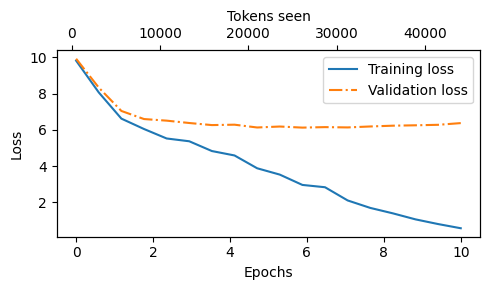

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    """
    Plot training and validation loss curves.

    Shows:
      - Loss vs epochs (primary x-axis)
      - Tokens processed vs loss (secondary x-axis)
    """

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss vs epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses,
        linestyle="-.", label="Validation loss"
    )

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Ensure integer tick marks for epochs
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Secondary x-axis showing tokens processed
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for alignment
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()


# Create evenly spaced epoch values matching number of recorded losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

# Plot loss curves
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)